![toy](assets/my-first/toy.jpg)

(image: flickr)

# My first machine learning model

In this workshop, we will walk through creating and training a simple machine learning model from scratch.

Through out the course, we'll be repeating the tasks in this process for different machine learning algorithms.

### Data Science Process

![workflow](assets/intro/ds.png)

(image: szilard)

### What we will cover today

1. Data transformation and cleaning
2. Feature selection
3. Model creation and training
4. Model validation
5. Undestanding results and iterating

### Prediction Task

For our first machine learning problem, we will try to predict Singapore's Foreign Reserves based on Gross Domestic Product (GDP).

### Datasets
1. Gross Domestic Product at Current Prices, Annual: https://data.gov.sg/dataset/income-components-of-gross-domestic-product-at-current-prices-annual
2. Total Foreign Reserves: https://data.gov.sg/dataset/total-foreign-reserves


- Download both datasets
- Note their paths for use later, when we call `pandas.read_csv`.

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Data Transformation and Cleaning

The first step is to inspect the data. We are looking for a relationship between GDP and Foreign Reserves.

First, we have the Annual Gross Domestic Product, which is our independent variable.

Let's notate it as `x`, so the corresponding DataFrame will be `df_x`.

In [107]:
df_x = pd.read_csv('D:/tmp/income-components-of-gross-domestic-product-at-current-prices-annual/gross-domestic-product-at-current-market-prices-annual.csv',
                parse_dates=['year'], index_col=0)
df_x.head()

,level_1,value
year,,
1980-01-01,GDP At Current Market Prices,25863.4
1981-01-01,GDP At Current Market Prices,30344.7
1982-01-01,GDP At Current Market Prices,33969.8
1983-01-01,GDP At Current Market Prices,38039.1
1984-01-01,GDP At Current Market Prices,41702.0


Next, we have the Annual Total Foreign Reserves, which is our **dependent** variable (we think it is dependent on X).

Let's notate is as `y`, so the corresponding DataFrame will be `df_y`.

In [108]:
df_y = pd.read_csv('D:/tmp/total-foreign-reserves/total-foreign-reserves-annual.csv',
                parse_dates=['year'], index_col=0)
df_y.head()

,total_foreign_reserve_sgd,special_drawing_rights,imf_reserve_position,gold_and_foreign_exchange,total_foreign_reserve_usd
year,,,,,
1963-01-01,1151.4,0.0,0.0,1151.4,376.3
1964-01-01,1138.1,0.0,0.0,1138.1,370.7
1965-01-01,1068.6,0.0,0.0,1068.6,349.2
1966-01-01,1207.3,0.0,23.0,1184.3,392.0
1967-01-01,1517.2,0.0,23.0,1494.2,494.2


Looks like `df_x` has a different date range than `df_y`. Let's print the ranges to confirm:

In [109]:
print('Time range of df_x:', df_x.index.values.min(), df_x.index.values.max())
print('Time range of df_y:', df_y.index.values.min(), df_y.index.values.max())

Time range of df_x: 1980-01-01T00:00:00.000000000 2016-01-01T00:00:00.000000000
Time range of df_y: 1963-01-01T00:00:00.000000000 2014-01-01T00:00:00.000000000


### Joining the datasets

Since we have two datasets, let's join them into a single DataFrame.

We will do:
- a left join of `df_y` onto `df_x`, and
- drop any NaN values

This will also take care of the different date ranges.

In [110]:
df = df_x.join(df_y).dropna()
df

,level_1,value,total_foreign_reserve_sgd,special_drawing_rights,imf_reserve_position,gold_and_foreign_exchange,total_foreign_reserve_usd
year,,,,,,,
1980-01-01,GDP At Current Market Prices,25863.4,13757.7,42.7,126.1,13588.9,6571.6
1981-01-01,GDP At Current Market Prices,30344.7,15491.1,75.6,173.0,15242.5,7564.8
1982-01-01,GDP At Current Market Prices,33969.8,17917.9,127.5,183.1,17607.3,8497.9
1983-01-01,GDP At Current Market Prices,38039.1,19755.3,150.9,184.9,19419.5,9287.9
1984-01-01,GDP At Current Market Prices,41702.0,22768.0,147.3,186.2,22434.5,10453.6
1985-01-01,GDP At Current Market Prices,40823.9,27070.9,164.9,212.2,26693.8,12860.3
1986-01-01,GDP At Current Market Prices,40854.3,28157.5,195.4,228.8,27733.3,12946.0
1987-01-01,GDP At Current Market Prices,45502.5,30441.7,224.5,240.5,29976.7,15232.3
1988-01-01,GDP At Current Market Prices,53360.2,33276.6,232.7,228.3,32815.6,17098.2


### Scatter plot to inspect possible relationships

Let's also plot the relationship between X and Y.

Between 2 or 3 variables, a scatter plot is useful to see if the (x, y) points lie on some sort of line or curve.

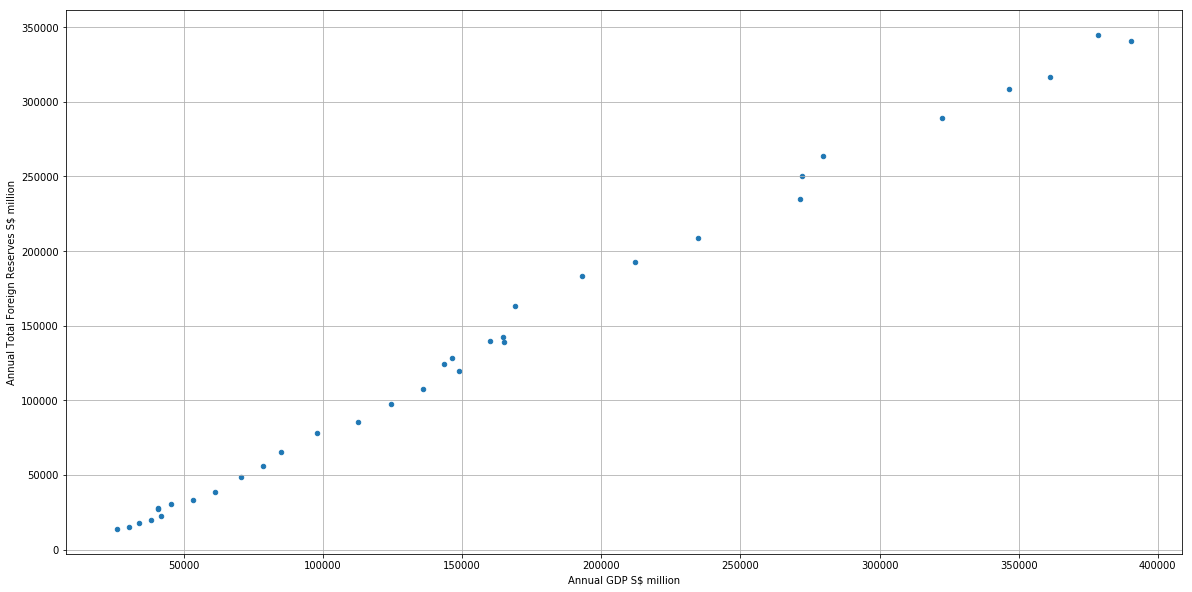

In [124]:
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(kind='scatter', x='value', y='total_foreign_reserve_sgd', ax=ax)

ax.set(xlabel='Annual GDP S$ million', ylabel='Annual Total Foreign Reserves S$ million')
ax.grid()

Play around with other columns as well, to explore the data further and observe other relationships.

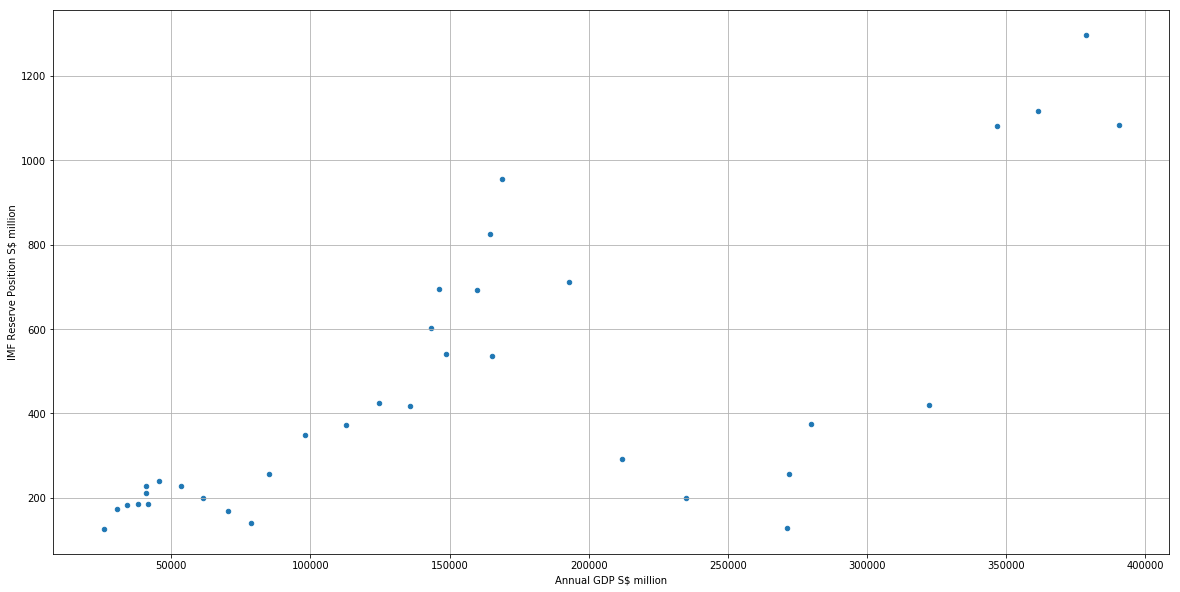

In [123]:
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(kind='scatter', x='value', y='imf_reserve_position', ax=ax) # less linear

ax.set(xlabel='Annual GDP S$ million', ylabel='IMF Reserve Position S$ million')
ax.grid()

### 2. Feature selection

For this simple task, feature selection is straightforward. 

No further transformation is needed because:
- The data is already in numerical format, and we've dropped missing values.
- There's only one feature, so there no need to normalize the features by scaling or re-centering them.

### Inputs

|Feature|Description|Column name|Transformation Needed|
|--|--|--|
|$x_1$|Annual GDP S$ million|value|None|

### Outputs

|Output|Description|Truth Column name|Transformation Needed|
|--|--|--|
|$\hat{y}$|Predicted Annual Foreign Reserves S$ million|total_foreign_reserve_sgd|None|


### 3. Model creation and training

In this section, we'll train a simple single-variable Linear Regression model.

### Linear Regression

Textbook definition:
- Linear regression takes a vector x ($x \in \Re$) as input, and predicts the value of a scalar y ($y \in \Re$) as output.
- Let $\hat{y}$ be the value that the model predicts, then:

$$\hat{y} = w^Tx,$$

where
- $w^Tx$ is known as the **linear function** of the input
- $w \in \Re$ are the parameters or weights of that linear function

(Reference: Deep Learning - Goodfellow, Bengio, Courville, MIT press, 2016)

### Application to our problem

This table summarizes how Linear Regression will be applied to our machine learning problem.

|Variable|What it is|What are its values|How is it used|
|--|--|--|
|$x_1$|Scalar feature|Annual GDP|Used as training inputs|
|$w_1$|Scalar weight|Learned by model|Used for computing $\hat{y}$|
|$\hat{y}$|Scalar prediction|Result of $w^Tx$|Used for training output|
|$y$|Scalar truth|Annual Foreign Reserves|Used for minimizing training error (cost)|

Note that we use subscripts here, $x_1$ and $w_1$ because we only have a scalar input value.

### Linear Function: Details
You may recall that a linear function has an intercept term, $b$

$$\hat{y} = w_1x_1 + b$$

This is also known as the "bias" term, because it is a constant.

For convenience, this is represented as:

$$\hat{y} = w_0x_0 + w_1x_1$$ 

where $x_0 = 1$, and $w_0 = b$

This can be represented with the following vector-matrix operation:

$$\hat{y} = \left(\begin{array}{c c}
   w_0 & w_1
\end{array} \right) \left(\begin{array}{c}
   x_0 \\
   x_1
\end{array} \right)$$

$$\hat{y} = w^Tx$$

Let's represent this model in Python.  We will be using [scikit-learn](http://scikit-learn.org/), a machine learning library.